# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                                                           --------------  ----- 
 0   total_images	last_price	total_area	first_day_exposition	rooms	ceiling_height	floors_total	living_area	floor	is_apartment	studio	open_plan	kitchen_area	balcony	locality_name	airports_nearest	cityCenters_nearest	parks_around3000	parks_nearest	ponds_around

Была импортирована библиотека pandas, создан датасет data, в который загрузили файл с данными. При просмотре содержимого выяснилось, что данные в строках записаны  слитно, из-за чего в таблице существовал один столбец. </b>

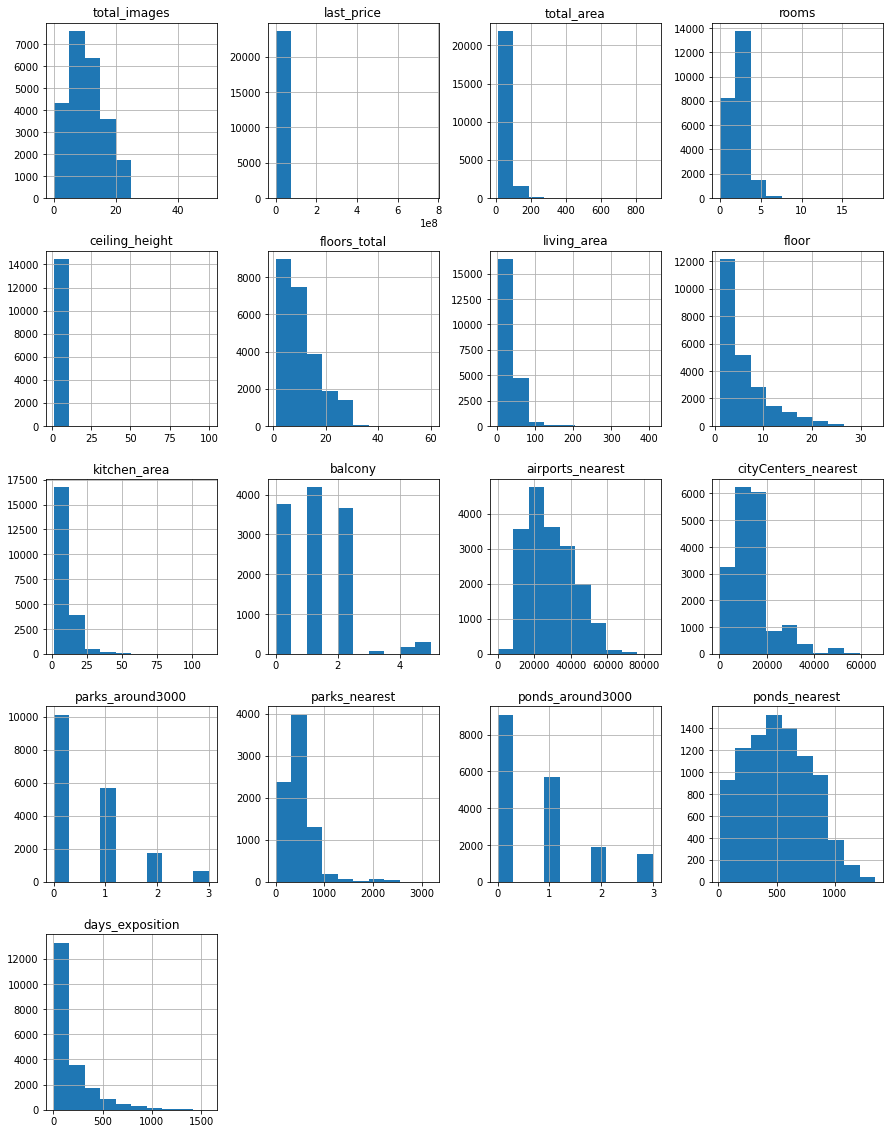

In [7]:
data.hist(figsize=(15, 20));

### Предобработка данных

In [8]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В разных колонках встречаются отстутствующие значения NaN. Надо определить, что могут означать эти значения и избавиться от них в зависимости от того, что они могут означать. Например, в колонке "is_apartment" это будет булев тип, то есть либо False, либо True и достаточно определить к какому типу относиться NaN. А в колонке "living_area" это будут по какой либо причине пропущенные значения, которые нельзя просто удалить или обнулить. Определим в каких столбцах попадается NaN

In [9]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В 14 столбцах попадается нулевое значение. Необходимо определить характер этих отсутствующих значений и избавиться от них, так как они могут помешать анализу данных. В колонке "ceiling_height" находятся данные о высоте потолков. Посчитаем, сколько раз встречается NaN

In [10]:
data['ceiling_height'].isna().sum()

9195

В 9195 строках из 23699 встречается NaN. Скорее всего данные о высоте потолков просто не внесли. Чтобы отсутствующие значения не искажали аналитические данные, вместо NaN можно внести среднее значение высоты потолков, либо их медиану, для чего надо посмотреть насколько разбросаны имеющиеся данные. Посмотрим с помощью метода descrybe список характерных значений для выбранной колонки

In [11]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Среднее значение составляет 2.771499. Это вполне нормальное значение для высоты потолков. Однако минимальное и максимальное значения составляют 1 и 100, что не может быть нормальным. Надо понять насколько много таких значений, чтобы принять решение об их исключении

In [12]:
data[data['ceiling_height'] < 2.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,NaN,...,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


Посмотрим также на ситуацию с максимальной высотой потолков.

In [13]:
data[data['ceiling_height'] > 4.0].sort_values(by=['ceiling_height'], ascending=False).head(30)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,...,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,...,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,...,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
22938,14,4000000.0,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,...,9.0,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0
21824,20,2450000.0,44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,...,8.6,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10773,8,3800000.0,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,...,8.1,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0
17857,1,3900000.0,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,...,NaN,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0
20478,11,8000000.0,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,NaN,...,10.0,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0


Значение 100,0 встречается 1 раз и скорее всего является ошибкой, как и значения менее 1,75 и их скорее всего можно заменить на медиану. Значения от 24,0 до 32,0 вероятно записаны в дециметрах и их надо заменить на значения в метрах - от 2,4 до 3,2

In [14]:
data.loc[data['ceiling_height'] >= 20.0, 'ceiling_height']= data['ceiling_height']*0.1

In [15]:
data.loc[(
    data['ceiling_height'] == 100.0, 'ceiling_height')
    and (data['ceiling_height'] < 2.0, 'ceiling_height')]= data['ceiling_height'].median()

In [16]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.729883
std          0.319173
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64

После замены ошибочных значений медиану немного изменилось, а максимальное стало равно 14. Для высоты потолков жилого помещения это очень много. Надо посмотреть сколько осталось строк с аномальными значениями высоты выше 4 метров

In [17]:
len(data[data['ceiling_height']>4.0])

53

Таких строк 53 из 23699. Сложно понять, что имелось в виду, когда указывалась такая высота потолков, возможно то просто ошибка при внесении данных. Скорее всего значения высоты больше 4 метров также можно изменить на медиану.

In [18]:
data.loc[data['ceiling_height'] > 4.0, 'ceiling_height'] = data['ceiling_height'].median()

In [19]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.720565
std          0.257694
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          4.000000
Name: ceiling_height, dtype: float64

Среднее значение изменилось незначительно. Теперь можно избавиться от значений NaN

In [20]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [21]:
data['floors_total'].isna().sum()

86

В колонке floors_total указано количество этажей в здании, пропущенные значение скорее всего забыли внести. В колонке floors внесено на каком этаже находится квартира. Вероятно правильным будет заменить пропущенное значение номером этажа, на котором располагается квартира.

In [22]:
data['floors_total'] = data['floors_total']. fillna(data['floor'])

От значений NaN колонке floors_total избавились. Теперь поработаем с колонкой living_area

In [23]:
data['living_area'].isna().sum()

1903

Непонятно, почему отсутствуют значения в колонке living_area, выкинуть такие строки из таблицы нельзя, так как их немало. К тому же значения жилой площади довольно значимый показатель, который может повлиять на результаты анализа. Скорее всего можно  будет заполнить эти значения результатом вычисления средней площади. Для этого наведем порядок в колонке с наименованием населенных пунктов, так как там присутствуют аномалии

In [25]:
data[data['living_area'] > data['total_area']].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [26]:
data['is_apartment'].isna().sum()

20924

In [27]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Апартамены являются нежилыми помещениями, в которых невозможная регистрация. Чаще всего это коммерческая недвижимость. Значения в столбце is_apartment являются булевыми, либо да, либо нет. Значений True гораздо меньше, поэтому можно предположить, что значения NaN также являются False.

In [28]:
data['is_apartment'] = data['is_apartment'].fillna(False)


По нашему мнению строки с апартаментами необходимо удалить, так как это нежилая недвижимость и данные, содержащиеся в таких строках могут искажать данные при анализе.

In [29]:
data.drop(data[data.is_apartment == True].index, inplace=True)

In [30]:
data['is_apartment'].value_counts()

False    23649
Name: is_apartment, dtype: int64

Далее проработаем колонку kitchen_area

In [31]:
data['kitchen_area'].isna().sum()

2263

In [32]:
data['kitchen_area'].describe()

count    21386.000000
mean        10.558093
std          5.869661
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Количество значений NaN колонке kitchen_area довольно большое, чтобы выкидывать эти строки, поэтому заполним пропущенные значения медианными

In [34]:
data[data['kitchen_area'] > data['total_area']].head(23699)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


В колонке balcony очень много строк с пропущенными значениями. Возможно продавец не проставил ничего, потому что балкона нет. Поэтому будет логичным заменить NaN на ноль.

In [35]:
data['balcony'] = data['balcony'].fillna(0)

In [36]:
data['balcony'] = data['balcony'].astype(int)

В колонке airports_nearest 5542 значения NaN. Причины, по которым не заполнены эти значения, сложно понять. Может быть населенный пункт настолько далеко от аэропорта, что для продажи квартиры это несущественная категория. Может быть просто забыли заполнить или данные потерялись. Возможно лучшим вариантом будет заполнить NaN медианой.

В колонке cityCenters_nearest также можно заменить отстутствующие значения медианой.

In [39]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1895
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2263
balcony                     0
locality_name              49
airports_nearest         5533
cityCenters_nearest      5512
parks_around3000         5511
parks_nearest           15589
ponds_around3000         5511
ponds_nearest           14569
days_exposition          3169
dtype: int64

Отсутствующие значения остались в колонках c указанием жилой площади и с расстоянием до парков и водоемов, а также с количеством дней размещения объявления. Если посмотреть на колонки с количеством парков и водоемов рядом с квартирой, то увидим, что там NaN совпадают, поэтому вполне вероятно, что эти пропуски означают отсутствие парков и водоемов ближе 3000м. Поэтому можно пропущенным значениям в колонках parks_around3000 и ponds_around3000 присвоить значение 0, а в колонках parks_nearest и ponds_nearest значение больше 3000м

Столбец days_exposition со значениями NaN. Выяснить, почему эти значения появились, довольно сложно, выкинуть эти строки будет неправильным, так как их почти 10% от общего числа, поэтому скорее всего будет верным заполнить отсутствующие значения медианой.

In [41]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1895
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2263
balcony                     0
locality_name              49
airports_nearest         5533
cityCenters_nearest      5512
parks_around3000         5511
parks_nearest           15589
ponds_around3000         5511
ponds_nearest           14569
days_exposition          3169
dtype: int64

In [42]:
data['rooms'].describe()

count    23649.000000
mean         2.070616
std          1.078139
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

(1.0, 20.0)

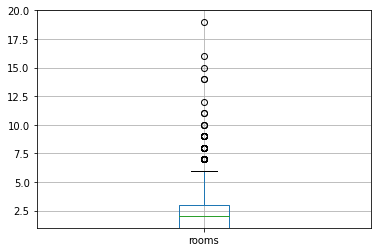

In [43]:
data.boxplot(column='rooms');# в колонке rooms наблюдаются выбросы. Подсчитаем количество строк с количеством комнат более 6
plt.ylim(1, 20)

In [44]:
len(data[data['rooms']>6])#data['rooms'].value_counts()#строк с количеством комнат более 6 менее 10%, поэтому удалим эти строки

89

In [45]:
data.drop(data[data.rooms > 6].index, inplace=True)

In [46]:
data['total_area'].describe()

count    23560.000000
mean        59.466243
std         31.853130
min         12.000000
25%         40.000000
50%         52.000000
75%         69.100000
max        500.000000
Name: total_area, dtype: float64

(1.0, 500.0)

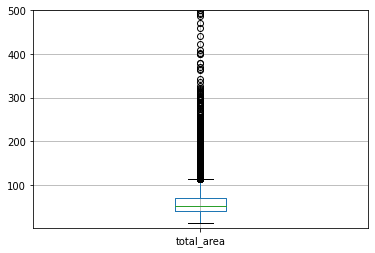

In [47]:
data.boxplot(column='total_area');# в колонке rooms наблюдаются выбросы. Подсчитаем количество строк с количеством комнат более 6
plt.ylim(1, 500)

In [48]:
len(data[data['total_area']>100])# количество выбросов выше 100кв.м. не превышает 10%, поэтому удалим их

1738

In [49]:
data.drop(data[data.total_area > 100].index, inplace=True)

### Посчитайте и добавьте в таблицу новые столбцы

Далее определим границы ценовых групп и создадим столбец с такими группами.

In [50]:
data['last_price'].describe()

count    2.182200e+04
mean     5.082396e+06
std      2.950997e+06
min      4.300000e+05
25%      3.300000e+06
50%      4.450000e+06
75%      6.096925e+06
max      5.300000e+07
Name: last_price, dtype: float64

(0.0, 40000000.0)

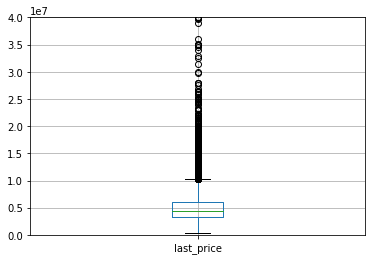

In [51]:
data.boxplot(column='last_price');
plt.ylim(0, 40000000)

In [52]:
last_price = data.query('last_price > 11000000').sort_values(by='last_price', ascending=True)
last_price

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
15226,17,11050000.0,72.0,2017-08-18T00:00:00,2,2.65,5.0,NaN,3,False,...,NaN,False,Санкт-Петербург,36813.0,8572.0,1.0,2467.0,3.0,214.0,110.0
17495,19,11050000.0,79.3,2019-01-29T00:00:00,3,2.50,17.0,46.00,14,False,...,10.9,False,Санкт-Петербург,17390.0,16804.0,1.0,172.0,0.0,NaN,NaN
2708,1,11060000.0,51.2,2018-02-16T00:00:00,1,3.00,7.0,15.00,5,False,...,17.4,True,Санкт-Петербург,39412.0,10186.0,1.0,1424.0,3.0,204.0,90.0
21573,4,11066961.0,86.8,2018-12-25T00:00:00,3,2.75,10.0,45.85,8,False,...,NaN,False,Санкт-Петербург,17518.0,6168.0,0.0,NaN,0.0,NaN,NaN
21046,2,11080008.0,75.1,2018-12-30T00:00:00,2,3.00,19.0,33.03,14,False,...,NaN,False,Санкт-Петербург,22875.0,9238.0,1.0,124.0,1.0,507.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8322,20,39900000.0,55.3,2017-10-26T00:00:00,1,3.05,6.0,35.00,4,False,...,8.0,True,Санкт-Петербург,25685.0,2136.0,1.0,72.0,3.0,202.0,NaN
12916,6,39990000.0,67.7,2015-06-25T00:00:00,3,3.10,7.0,42.90,6,False,...,9.0,False,Санкт-Петербург,25685.0,2136.0,1.0,72.0,3.0,202.0,NaN
6127,13,40000000.0,65.3,2017-07-13T00:00:00,2,2.65,5.0,45.00,2,False,...,12.0,True,Санкт-Петербург,23308.0,2380.0,1.0,473.0,1.0,283.0,497.0
7726,20,50000000.0,93.0,2019-04-18T00:00:00,2,2.65,7.0,40.00,4,False,...,28.0,True,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,NaN


Мы видим, что в ценах на квартиры есть выброс, который может повлиять на результаты анализа. Такой выброс единичный, поэтому будет целесообразнее удалить строку с аномально высокой ценой. Также надо посмотреть есть ли аномально низкие цены

In [53]:
data.drop(data[data.last_price > 11000000].index, inplace=True) #удалим строку с аномально высокой ценой

In [54]:
data[data['last_price'] < 1000000].sort_values(by=['last_price'], ascending=True).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,2.65,3.0,NaN,3,False,...,NaN,False,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,2.65,2.0,16.0,1,False,...,6.0,False,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16274,18,440000.0,40.0,2018-07-10T00:00:00,1,2.65,5.0,NaN,1,False,...,NaN,False,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17676,0,450000.0,36.5,2018-02-01T00:00:00,1,2.65,5.0,17.3,4,False,...,8.5,True,деревня Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120.0
5698,7,450000.0,42.0,2017-07-31T00:00:00,2,2.65,1.0,23.0,1,False,...,5.8,False,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
9581,7,450000.0,43.4,2018-08-31T00:00:00,2,2.65,5.0,30.3,3,False,...,5.5,False,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
16219,14,450000.0,38.5,2018-07-11T00:00:00,2,2.65,2.0,NaN,1,False,...,NaN,False,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
21912,0,470000.0,37.0,2018-02-18T00:00:00,1,2.65,3.0,NaN,3,False,...,NaN,False,поселок Совхозный,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23484,11,470000.0,44.5,2018-07-02T00:00:00,2,2.65,2.0,28.0,2,False,...,7.5,False,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,298.0
18867,1,470000.0,41.0,2018-02-11T00:00:00,1,2.65,5.0,32.0,3,False,...,9.0,False,деревня Выскатка,NaN,NaN,NaN,NaN,NaN,NaN,46.0


In [55]:
data.drop(data[data.last_price < 400000].index, inplace=True) #удалим строку со значением менее 400000

Создадим колонку, в которой распределим населенные пункты по трем категориям: город, поселок, деревня.

In [56]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [57]:
data['locality_name'].isna().sum()

41

In [58]:
data = data.dropna(subset=['locality_name']) # строк со значением NaN не так много, 
#вряд ли их удаление может повлиять на результаты анализа
data['locality_name'].isna().sum()

0

In [59]:
row = data['locality_name']
def locality_association(row):
    if 'посел' in row or 'посёл' in row:
        return 'поселок'
    if 'деревня' in row or 'садовод' in row or 'село' in row:
        return 'деревня'
    return 'город'

data['locality'] = data['locality_name'].apply(locality_association)
data['locality'].unique()

array(['поселок', 'город', 'деревня'], dtype=object)

Теперь необходимо посмотреть на типы колонок и определить, все ли подходят для дальнейшего анализа.

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20939 entries, 1 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20939 non-null  int64  
 1   last_price            20939 non-null  float64
 2   total_area            20939 non-null  float64
 3   first_day_exposition  20939 non-null  object 
 4   rooms                 20939 non-null  int64  
 5   ceiling_height        20939 non-null  float64
 6   floors_total          20939 non-null  float64
 7   living_area           19311 non-null  float64
 8   floor                 20939 non-null  int64  
 9   is_apartment          20939 non-null  bool   
 10  studio                20939 non-null  bool   
 11  open_plan             20939 non-null  bool   
 12  kitchen_area          18937 non-null  float64
 13  balcony               20939 non-null  bool   
 14  locality_name         20939 non-null  object 
 15  airports_nearest   

Мы видим, что колонке с датой первой публикации присвоен тип object. Это помешает нам в дальнейшем анализе, надо преобразовать тип колонки в формат datetime.

In [61]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20939 entries, 1 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20939 non-null  int64         
 1   last_price            20939 non-null  float64       
 2   total_area            20939 non-null  float64       
 3   first_day_exposition  20939 non-null  datetime64[ns]
 4   rooms                 20939 non-null  int64         
 5   ceiling_height        20939 non-null  float64       
 6   floors_total          20939 non-null  float64       
 7   living_area           19311 non-null  float64       
 8   floor                 20939 non-null  int64         
 9   is_apartment          20939 non-null  bool          
 10  studio                20939 non-null  bool          
 11  open_plan             20939 non-null  bool          
 12  kitchen_area          18937 non-null  float64       
 13  balcony         

Теперь добавим колонки с ценой одного квадратного метра, днем, месяцем и годом публикации объявления, типом этажа квартиры, расстоянием в км до центра города.

In [62]:
data['price_per_sqare'] = round((data['last_price']/data['total_area']), 2)

In [63]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
for index in data['weekday']:
    if index == 0:
        data['weekday'] = data['weekday'].replace(0, 'вск')
    elif index == 1:
        data['weekday'] = data['weekday'].replace(1, 'пн')    
    elif index == 2:
        data['weekday'] = data['weekday'].replace(2, 'вт')
    elif index == 3:
        data['weekday'] = data['weekday'].replace(3, 'ср')
    elif index == 4:
        data['weekday'] = data['weekday'].replace(4, 'чт')
    elif index == 5:
        data['weekday'] = data['weekday'].replace(5, 'пт')
    else:
        data['weekday'] = data['weekday'].replace(6, 'сб')
        
data['weekday'].unique()

array(['пн', 'ср', 'вск', 'вт', 'сб', 'пт', 'чт'], dtype=object)

In [64]:
def check_floor(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'

data['type_floor'] = data.apply(check_floor, axis=1)
data['type_floor'].unique()
    

array(['первый', 'другой', 'последний'], dtype=object)

In [65]:
data['distance_cityCenters_km'] = round((data['cityCenters_nearest']/1000), 0)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality,price_per_sqare,year,month,weekday,type_floor,distance_cityCenters_km
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,0.0,NaN,81.0,поселок,82920.79,2018,12,пн,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,2.0,574.0,558.0,город,92785.71,2015,8,ср,другой,14.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,город,100000.00,2018,6,пн,другой,8.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,False,...,NaN,NaN,55.0,поселок,95065.79,2018,9,вск,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,...,0.0,NaN,155.0,поселок,99195.71,2017,11,ср,другой,19.0


### Проведите исследовательский анализ данных

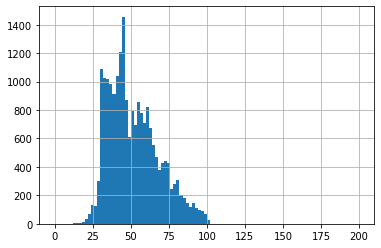

In [66]:
data['total_area'].hist(bins=100, range=(0, 200));

Среди объявлений преобладают квартиры с площадью примерно 40-45кв.м. Затем резко снижается количество жилья с площадью около 50кв.м, потом наблюдается увеличение площади до 60кв.м. и относительно плавное снижение до 200кв.м.

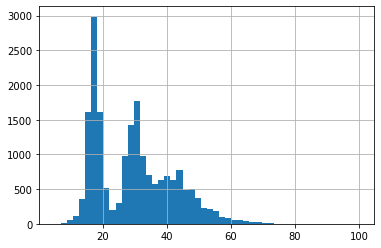

In [67]:
data['living_area'].hist(bins=50, range=(5, 100));

In [68]:
data['living_area'].value_counts().head();

Гистограмма по жилой площади показывает интересные значения: пики (30кв.м., 18кв.м.). Скорее всего это связано с тем, что в основном продаются 1 и 2 комнатные квартиры, которые как раз имеют такую жилую площадь.

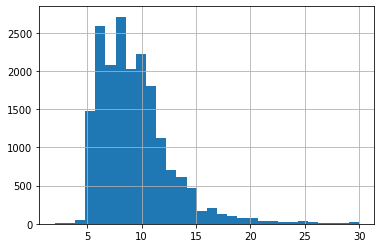

In [69]:
data['kitchen_area'].hist(bins=30, range=(2, 30));

Ситуация по площади кухни примерно похожа на общую площадь квартир: быстрый взлет площади к 6кв.м., затем небольшое падение и увеличение количества кухонь с площадью 8-9 кв.м.. Затем плавное снижение количества кухонь с большей площадью.

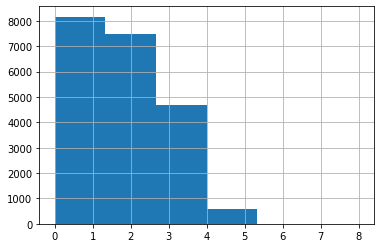

In [70]:
data['rooms'].hist(bins=data['rooms'].max(), range=(0, 8));

На гистограмме по количеству комнат мы видим, что в части объявлений указано, что количество комнат 0. Надо посмотреть, почему возникла такая аномалия и постараться исправить её.

In [71]:
data.sort_values(by=('rooms'), ascending=True).head(50)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality,price_per_sqare,year,month,weekday,type_floor,distance_cityCenters_km
17582,11,2680000.0,22.00,2018-08-11,0,2.65,25.0,5.00,8,False,...,1.0,652.0,70.0,город,121818.18,2018,8,пт,другой,12.0
15606,4,3499000.0,25.00,2019-04-05,0,2.80,14.0,17.00,13,False,...,0.0,NaN,NaN,город,139960.00,2019,4,чт,другой,16.0
21758,0,2330000.0,23.00,2018-01-01,0,2.65,24.0,2.00,22,False,...,NaN,NaN,66.0,поселок,101304.35,2018,1,вск,другой,NaN
17954,5,2700000.0,31.00,2017-10-26,0,2.65,17.0,21.60,6,False,...,1.0,552.0,51.0,город,87096.77,2017,10,ср,другой,16.0
16144,7,2500000.0,22.30,2019-01-11,0,2.65,21.0,18.00,7,False,...,NaN,NaN,4.0,город,112107.62,2019,1,чт,другой,NaN
1600,11,2550000.0,30.00,2017-11-10,0,2.75,23.0,15.90,11,False,...,1.0,429.0,19.0,город,85000.00,2017,11,чт,другой,17.0
16130,14,5000000.0,42.10,2018-04-13,0,2.65,20.0,30.00,10,False,...,0.0,NaN,170.0,город,118764.85,2018,4,чт,другой,16.0
18444,9,1900000.0,24.20,2017-09-08,0,2.65,15.0,18.10,1,False,...,NaN,NaN,30.0,поселок,78512.40,2017,9,чт,первый,NaN
20254,5,3200000.0,23.60,2018-07-13,0,3.10,4.0,17.00,1,False,...,0.0,NaN,67.0,город,135593.22,2018,7,чт,первый,2.0
10606,14,2950000.0,25.27,2017-11-17,0,2.65,25.0,25.00,11,False,...,1.0,623.0,51.0,город,116739.22,2017,11,чт,другой,13.0


Мы видим, что в основном квартиры, где внесено 0 комнат, небольшие по площади. Это скорее всего 1-комнатные квартиры и поэтому можно заполнить нулевые значения числом 1.

In [72]:
data['rooms'] = data['rooms'].replace(0, 1)

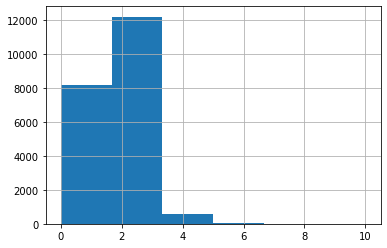

In [73]:
data['rooms'].hist(bins=data['rooms'].max(), range=(0, 10));

Ситуация поменялась значительно. В основном продаются 2 и 3 комнатные квартиры, примерно на 25% меньше 1 комнатных. Квартиры с большим количеством комнат продаются значительно меньше.

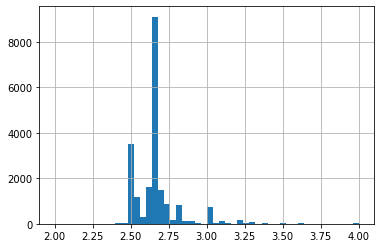

In [74]:
data['ceiling_height'].hist(bins=50, range=(2, 4));

В продаваемых квартирах в основном потолки, высотой примерно 2,6-2,65м. Также немало квартир с потолками 2,5м, но это меньше половины от большинства. И другая высота встречается довольно редко.

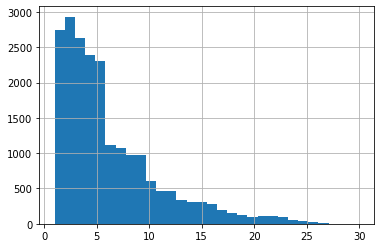

In [75]:
data['floor'].hist(bins=30, range=(1, 30));

В основном продаются квартиры на нижних этажах, самое большое количество на 2 этаже, чуть меньше на 1, затем идут 3, 4 и 5 этажи. После квартир на 5 этаже наблюдается резкое снижение до 6 этажа и затем более-менее плавное снижение количества квартир с увеличением этажности. Большое число продаваемых квартир на этажах до 5-го, связано с большим количеством так называемых "хрущевок" и "сталинок".

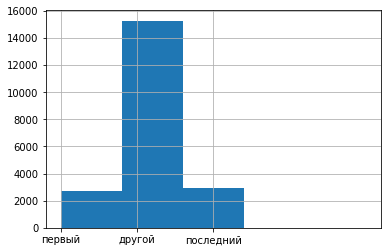

In [76]:
data['type_floor'].hist(bins=5, range=(0, 4));

Судя по этой гистрограмме наибольшее количество продаваемого жилья располагается не на первом и последнем этажах.

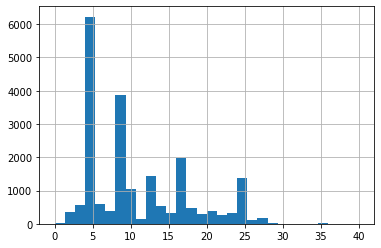

In [77]:
data['floors_total'].hist(bins=30, range=(0, 40));

Данные этой гистрограммы говорят о том, что среди продаваемого жилья преобладают 5-этажные дома и чуть больше половины от них 9-этажные дома. Скорее всего это вторичное жилье застройки советского периода. Также среди прочего жилья выделяются дома с 16, 12 и 25 этажами. Остальное жилье представлено незначительно.

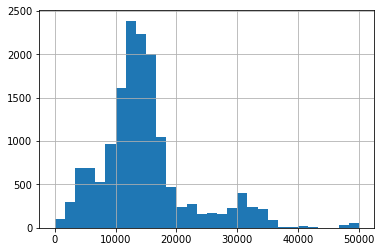

In [78]:
data['cityCenters_nearest'].hist(bins=30, range=(0, 50000));

In [79]:
data['cityCenters_nearest'].value_counts().head();

Основная часть продаваемого жилья нахожится на расстоянии от центра населенного пункта в пределах 10-20 км.

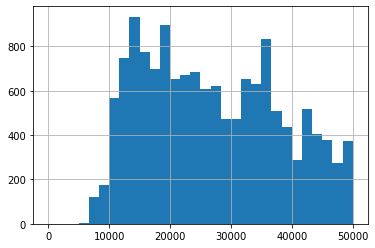

In [80]:
data['airports_nearest'].hist(bins=30, range=(0, 50000));

In [81]:
data['airports_nearest'].value_counts().head();

Ближе 7-8 километров к аэропорту квартир не продается. Пик квартир наблюдается на расстоянии примерно 14 км от ближайшего аэропорта. В целом после 14 километров количество продаваемого жилья медленно снижается, есть пики на расстояниях 20км и примерно 35-36км.

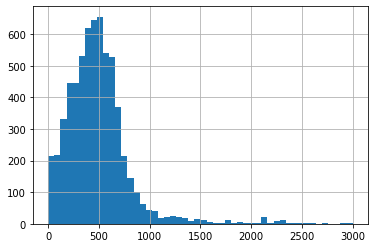

In [82]:
data['parks_nearest'].hist(bins=50, range=(0, 3000));

In [83]:
data['parks_nearest'].value_counts().head();

Гистограмма по колонке с расстоянием до ближайшего парка показывает, что количество продаваемых квартир резко увеличивается при удалении от парков до 450-500 метров, а затем примерно так же снижается.

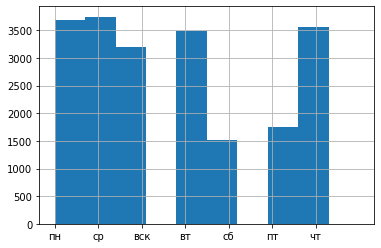

In [84]:
data['weekday'].hist(bins=10, range=(0, 7));

Здесь мы видим, что чаще всего объявления размещаются по средам, понедельникам, четвергам и вторникам. Далее с небольшим отрывом от них идет воскресенье. По пятницам и субботам объявления подаются гораздо реже. То есть вопросами по продаже квартиры люди начинают задаваться в основном среди недели и сразу после отдыха, а в дни перед выходными и в сами выходные занимаются другими делами.

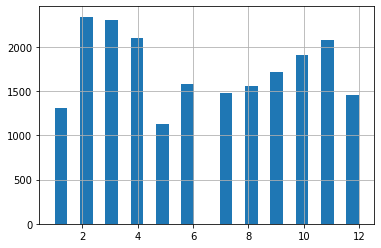

In [85]:
data['month'].hist(bins=24, range=(1, 12));

Судя по месячной гистограмме основная часть объявлений была размещена в конце зимы-начале весны (февраль-март-апрель) и ближе к концу осени (ноябрь-октябрь-сентябрь). Меньше всего публиковались в мае, январе и декабре. Связана такая статистика скорее всего с тем, что в предновогодние и посленовогодние дни, а также с началом лета и летом люди заняты больше вопросом отдыха и делами, связанными с продажей жилья, начинают заниматься как раз после проведения праздников и с окончанием отпускного периода.

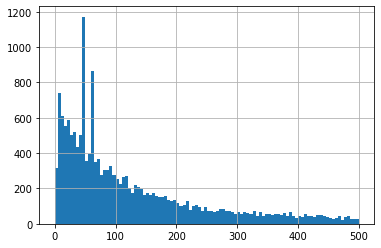

In [86]:
data['days_exposition'].hist(bins=100, range=(0, 500));

In [87]:
data['days_exposition'].describe()

count    18419.000000
mean       170.216190
std        208.039363
min          1.000000
25%         43.000000
50%         90.000000
75%        216.000000
max       1580.000000
Name: days_exposition, dtype: float64

Судя по гистрограмме колонки days_exposition квартиры продаются лучше в начале публикации. С увеличением времени публикации шансов на продажу пропорционально меньше. Быстрыми продажами можно назвать период от 1 до 43 дней с момента публикования объявления. Среднее количество дней со дня публикации до момента продажи 170 дней. Очень долгими продажами можно назвать период времени, начиная со 216 дня и далее.

Для определения факторов, наиболее влияющих на стоимость объекта, создадим сводные таблицы, объединяющие данные по стоимости квартиры, её общей площади, жилой площади, площади кухни, количеству комнат, типу этажа, на котором расположена квартира, дате размещения и на их основе построим графики.

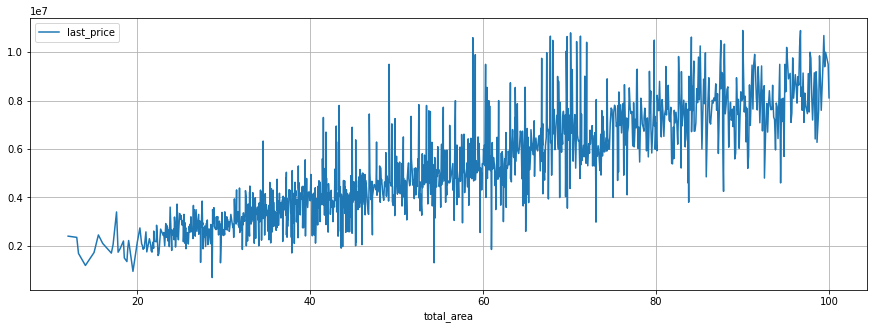

In [88]:
data.pivot_table(index='total_area', values='last_price').plot(grid=True, figsize=(15, 5));# на этом графике мы наблюдаем
#зависимость цены от общей площади квартиры,с увеличением площади растет цена, что выглядит довольно логичным

In [89]:
data['total_area'].corr(data['last_price'])# расчет коэффициента корреляции подтверждает, что между общей площадью и ценой
# квартиры есть взаимосвязь

0.6707068785109628

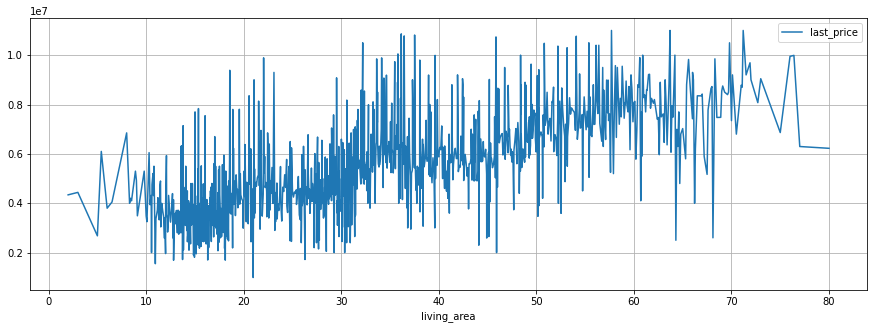

In [90]:
data.pivot_table(index='living_area', values='last_price').plot(grid=True, figsize=(15, 5));# увеличение жилой площади
#также приводит к росту стоимость квартиры. Рост менее заметен при площади до 50кв.м., затем нарастает.

In [91]:
data['living_area'].corr(data['last_price'])# взаимосвязь между величинами "жилая площадь" и "цена" чуть меньше, чем между
# общей площадью и ценой, но все равно есть

0.5337857591141767

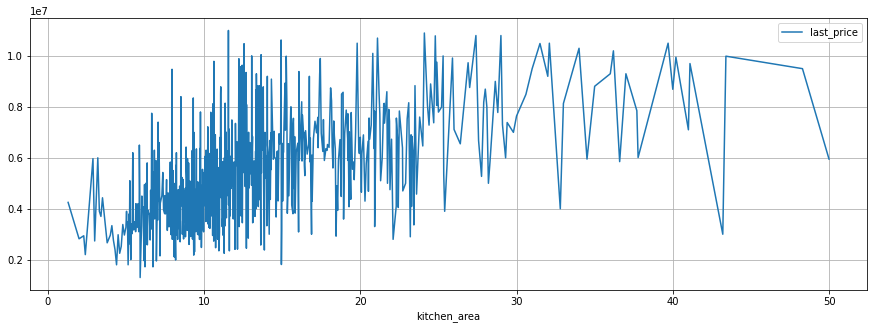

In [92]:
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, figsize=(15, 5));#рост стоимости
#при увеличении площади кухни менее заметен, чем в предыдущих случаях. Можно сказать, что размер
#кухни не самый значимый показатель для стоимости жилья

In [93]:
data['kitchen_area'].corr(data['last_price'])# расчет коэффициента корреляции это подтверждает

0.458622113422614

In [94]:
import seaborn as sns

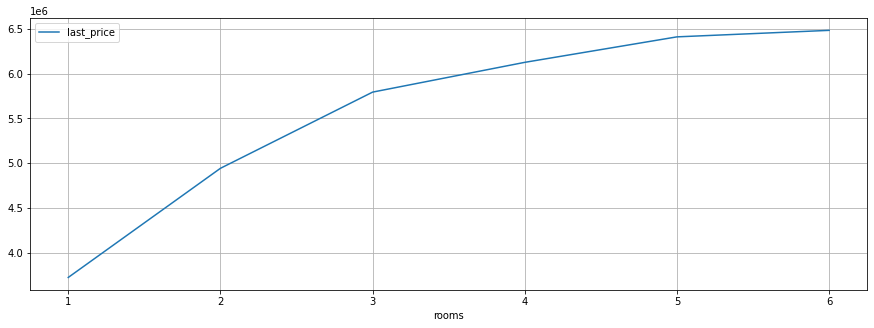

In [95]:
data.pivot_table(index='rooms', values='last_price').plot(grid=True, figsize=(15, 5));#здесь мы видим, что рост стоимости
#по мере увеличения числа комнат. Здесь наблюдается прямая зависимость стоимости от общей площади, так как с ростом числа 
#числа комнат увеличивается общая площадь жилья.

Здесь мы видим, что рост стоимости по мере увеличения числа комнат. Здесь наблюдается прямая зависимость стоимости от общей площади, так как с ростом числа числа комнат увеличивается общая площадь жилья.

In [96]:
data['rooms'].corr(data['last_price'])# здесь коэффициент корреляции не такой высокий, как у предыдущих показателей
# скорее всего это связано с тем, что определяющим фактором при установлении цены количество комнат не самая важная категория

0.40627872150195343

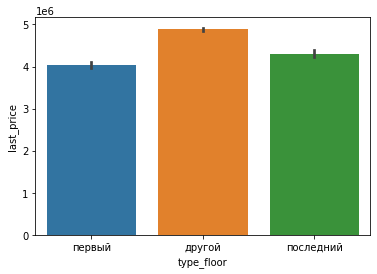

In [97]:
sns.barplot(x="type_floor", y="last_price", data=data);

Если смотреть на зависимость стоимости от типа этажа, то мы видим, что наиболее дорогие квартиры располагаются на этажах с типом "другой", затем идут квартиры на последних этажах и жилье, расположенное на первых этажах немного теряет в стоимости.

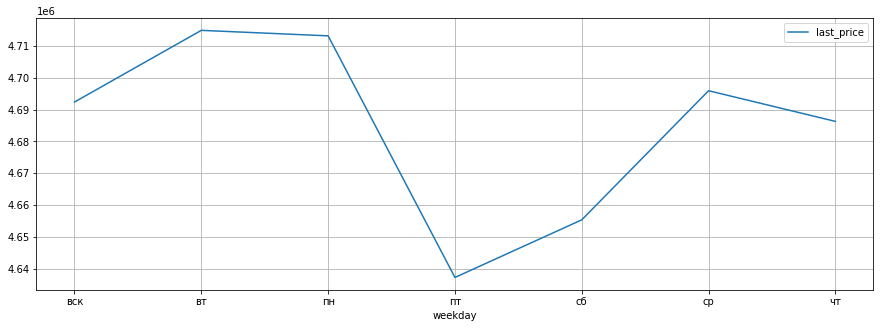

In [98]:
data.pivot_table(index='weekday', values='last_price').plot(grid=True, figsize=(15, 5));

По наибольшей стоимости размещены квартиры во вторник, понедельник и среду. Наименьшая стоимость у объявлений, размещенных в пятницу.

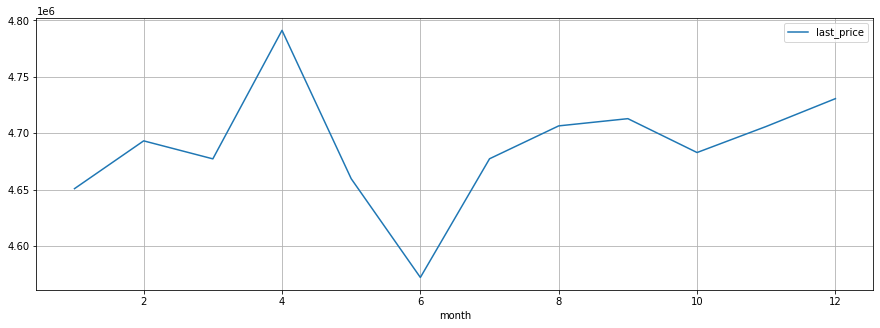

In [99]:
data.pivot_table(index='month', values='last_price').plot(grid=True, figsize=(15, 5));

Наиболее высокая цена у квартир, которые начинают продаваться в апреле. Затем идет декабрь, сентябрь, август и июль. Спад в цене наблюдается в июне. Также невыгодно продавать жилье в январе.

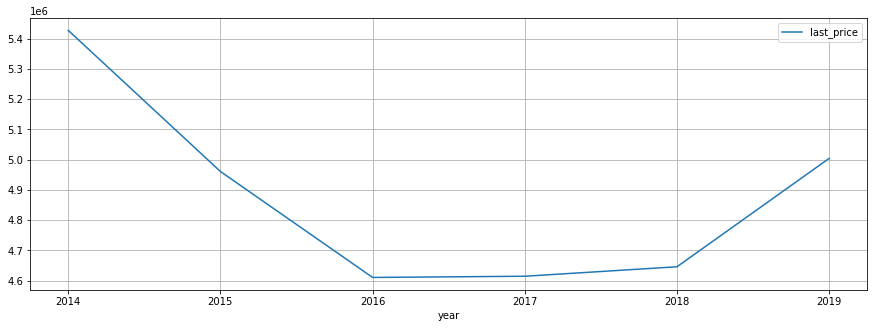

In [100]:
data.pivot_table(index='year', values='last_price').plot(grid=True, figsize=(15, 5));

Данный график показывает, что с 2014 наблюдается снижение стоимости жилья до 2016 года. Затем наблюдается небольшой рост до 2018 года и затем к 2019 году стоимость поднялась до уровня 2015 года.

В целом, судя по графикам, можно сказать, что наибольшее влияние на рост стоимости жилья влияет площадь, также надо обратить внимание, что по более высокой цене можно продать квартиру не на первом и последнем этажах, с числом комнат не менее 6.

Теперь определим среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [101]:
locality = data['locality_name'].value_counts().to_dict()#создаем словарь с населенными пунктами и количеством объявлений

In [102]:
locality_sort = pd.DataFrame(list(locality.items()), columns=['locality_name', 'amount'])#создадим таблицу из словаря
#с населенными пунктами
locality_sort.head(10)

,locality_name,amount
0,Санкт-Петербург,13195
1,посёлок Мурино,522
2,посёлок Шушары,431
3,Всеволожск,392
4,Пушкин,333
5,Колпино,332
6,посёлок Парголово,324
7,Гатчина,300
8,деревня Кудрово,297
9,Выборг,221


In [103]:
price = data.pivot_table(index='locality_name', values='price_per_sqare')#создаем словарь с населенными пунктами и 
# ценами за квадратный метр

In [104]:
locality_price = locality_sort.merge(price, on='locality_name')# объединяем две таблицы одну
#locality_price_distance = distance_cityCenters_km

In [105]:
locality_price.sort_values(by=['price_per_sqare'], ascending=False).head(10)#выводим 10 населенных пунктов
# с наиболее высокой ценой за квадратный метр


,locality_name,amount,price_per_sqare
238,посёлок Лисий Нос,2,121616.225000
0,Санкт-Петербург,13195,105487.693987
13,Сестрорецк,159,100862.034151
4,Пушкин,333,100350.205465
53,Зеленогорск,20,100123.735000
11,Кудрово,172,99903.345814
87,деревня Мистолово,11,98549.977273
320,посёлок Левашово,1,96997.690000
43,Мурино,33,93165.711515
8,деревня Кудрово,297,92392.915286


In [106]:
locality_price.sort_values(by=['price_per_sqare'], ascending=True).head(10)# выводим 10 населенных пунктов
# с наиболее низкой ценой за квадратный метр

,locality_name,amount,price_per_sqare
207,деревня Старополье,3,11206.220
253,посёлок станции Свирь,2,11481.480
296,деревня Вахнова Кара,1,11688.310
216,деревня Выскатка,2,12335.480
234,поселок Совхозный,2,12629.130
304,деревня Малая Романовка,1,12724.550
267,поселок Тёсово-4,1,12931.030
277,деревня Бор,1,13157.890
357,деревня Сижно,1,13709.680
254,деревня Ям-Тесово,2,13711.555


Здесь мы видим, что наиболее высокая цена за квадратный метр в городах и населенных пунктах, расположенных недалеко от Санкт-Петербурга. Наиболее низкая цена в населенных пунктах, расположенных на значительном отдалении от областного центра (деревня Старополье - 170км, посёлок станции Свирь - 285км, деревня Вахнова Кара - 189км).

Теперь посмотрим, как влияет удаленность от центра Санкт-Петербурга на стоимость жилья, а также рассчитаем среднюю цену каждого километра.

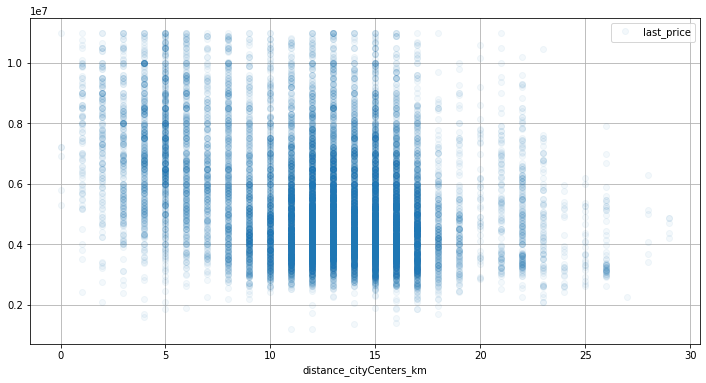

In [107]:
distance = data[['locality_name', 'distance_cityCenters_km', 'last_price']]#создаем таблицу с населенными пунктами
# и данными о расстоянии до центра города и ценой
distance_sort = distance.query('locality_name == "Санкт-Петербург"')#сделаем срез данных по Санкт-Петербургу
distance_sort.plot(x='distance_cityCenters_km', y='last_price',
                   style='o', figsize=(12, 6),alpha=0.05, grid=True);#создадим диаграмму
#рассеяния, чтобы увидеть зависимость цены от расстояния до центра города

Судя по диаграмме рассеяния наблюдается взаимосвязь между ценой и расстоянием. Также мы видим, что ближе к центру города разброс в ценовой категории более значительный. Теперь рассчитаем среднюю цену каждого километра.

In [108]:
price_mean = distance_sort['last_price'].sum()/data['distance_cityCenters_km'].sum()
price_mean

308050.94694770535

Средняя цена километра составляет 308050,95 руб.

### Общий вывод

В результате проведенного анализа мы выяснили, что в данных присутствуют отсутствующие значения, в частности в колонках о высоте потолков, количестве этажей, о наличии балкона, о жилой площади и так далее. Мы выявили определили вероятные причины этих значений, например в столбце о наличии балкона отсутствующее значение скорее всего означало отстутсутствие балкона, в столбце с количеством этажей такие значения совпадали с номером этажа, на котором располагается квартира, данные о высоте потолков вероятно забыли указать и мы заменили медианным значение нулевые показатели. Далее мы определили, что в данных присутствуют аномальные значения, выбивающиеся из общей картины. Такие значения были в данных о количестве комнат, о высоте потолков, о стоимости жилья и общей её площади. Мы выяснили, что количество таких данных не настолько большое (не более 10%), что их можно удалить, без ущерба для общей картины, а в случае их присутствия результаты анализа могли бы быть искаженными. Длее мы провели анализ влияния различных параметров на стоимость жилья и сделали следующие выводы:
 - Стоимость квартиры зависит от её площади; 
 - На цену влияет этаж, на котором располагается жилье: чем выше, тем дороже; 
 - Наиболее высокая стоимость квадратного метра жилья наблюдается в областном центре и населенных пунктах, расположенных недалеко от областного центра; 
 - Стоимость квартир растет в прямой зависимости от количества комнат; 
 - Среди объявлений преобладают квартиры 1 и 2 комнатные с общей площадью 40-45 кв.м. и жилой площадью 18 и 30 кв.м.; 
 - Основная часть продаваемых квартир имеет высоту потолка 2,60-2,65м, а также 2,5м; 
 - Основная часть жилья располагается на с 1 по 5 этажи, 2 этажи самые массовые, чаще всего квартиры находятся в 5 и 9 этажных домах; 
 - Основная часть продаваемого жилья нахожится на расстоянии от центра населенного пункта в пределах 10-15 км; 
 - Ближе 7-8 километров к аэропорту квартир не продается. Пик квартир наблюдается на расстоянии примерно 14 км от ближайшего аэропорта; 
 - Количество продаваемых квартир резко увеличивается при удалении от парков до 450-500 метров, а затем примерно так же снижается; 
 - Чаще всего объявления размещаются по средам, понедельникам, четвергам и вторникам. Далее с небольшим отрывом от них идет воскресенье. По пятницам и субботам объявления подаются гораздо реже; 
 - Основная часть объявлений была размещена в конце зимы-начале весны (февраль-март-апрель) и ближе к концу осени (ноябрь-октябрь-сентябрь). Меньше всего публиковались в мае, январе и декабре; 
 - Квартиры продаются лучше в начале публикации. С увеличением времени публикации шансов на продажу пропорционально меньше. Быстрыми продажами можно назвать период от 1 до 43 дней с момента публикования объявления. Среднее количество дней со дня публикации до момента продажи 170 дней. Очень долгими продажами можно назвать период времени, начиная со 216 дня и далее; 
 - Наибольшая стоимость наблюдается в объявлениях, размещенных во вторник, понедельник и среду. Наименьшая стоимость у объявлений, размещенных в пятницу. Наиболее высокая цена у квартир, которые начинают продаваться в апреле. Затем идет декабрь, сентябрь, август и июль. Спад в цене наблюдается в июне; 
 - С 2014 наблюдается снижение стоимости жилья до 2016 года. Затем наблюдается небольшой рост до 2018 года и затем к 2019 году стоимость поднялась до уровня 2015 года. 
 - Наиболее высокая цена за квадратный метр в городах и населенных пунктах, расположенных недалеко от Санкт-Петербурга. Наиболее низкая цена в населенных пунктах, расположенных на значительном отдалении от областного центра (деревня Старополье - 170км, посёлок станции Свирь - 285км, деревня Вахнова Кара - 189км).